In [130]:
import os
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # suppress Tensorflow verbose prints
warnings.simplefilter(action='ignore', category=FutureWarning)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [131]:
from form_train_data import load_data
import matplotlib.pyplot as plt
from scipy import spatial
from pathlib import Path
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np
import itertools
import random
import math
import cv2

data_path = Path.cwd() / 'data'
train_dataset_path = data_path / 'CASIA-WebFace-112x96'

## load data

In [3]:
print("CASIA pairs for training")
print("LFW pairs for testing")
casia_pairs, lfw_pairs = load_data(data_path)

Loading train data
Loading test data


In [89]:
print("shuffle casia list")
np.random.shuffle(casia_pairs)

shuffle casia_list


In [93]:
print("convert to pandas dataframe")
lfw_list = lfw_pairs.tolist()
casia_list = casia_pairs.tolist()
test_dataframe = pd.DataFrame(lfw_list)
train_dataframe = pd.DataFrame(casia_list) # takes long time

print("test dataframe")
print(test_dataframe)
print()
print("train dataframe")
print(train_dataframe)

convert to pandas dataframe
test dataframe
                                                  fileL  \
0                    Abel_Pacheco\Abel_Pacheco_0001.jpg   
1                Akhmed_Zakayev\Akhmed_Zakayev_0001.jpg   
2                Akhmed_Zakayev\Akhmed_Zakayev_0002.jpg   
3                  Amber_Tamblyn\Amber_Tamblyn_0001.jpg   
4                Angela_Bassett\Angela_Bassett_0001.jpg   
...                                                 ...   
5597                     Scott_Wolf\Scott_Wolf_0002.jpg   
5598  Sergei_Alexandrovitch_Ordzhonikidze\Sergei_Ale...   
5599                     Shane_Loux\Shane_Loux_0001.jpg   
5600                 Shawn_Marion\Shawn_Marion_0001.jpg   
5601     Slobodan_Milosevic\Slobodan_Milosevic_0002.jpg   

                                       fileR  flag  
0         Abel_Pacheco\Abel_Pacheco_0004.jpg     1  
1     Akhmed_Zakayev\Akhmed_Zakayev_0003.jpg     1  
2     Akhmed_Zakayev\Akhmed_Zakayev_0003.jpg     1  
3       Amber_Tamblyn\Amber_Tamblyn_

In [99]:
train_dataframe['flag'] = train_dataframe['flag'].astype(str)

## model

In [77]:
# def myphi(x,m):
#     x = x * m
#     return 1 - x**2/math.factorial(2) + x**4/math.factorial(4) - x**6/math.factorial(6) + x**8/math.factorial(8) - x**9/math.factorial(9)

# class MarginInnerProductLayer(tf.keras.layers.Layer):
#     def __init__(self, in_features, out_features, m=4, phiflag=True):
#         super(MarginInnerProductLayer, self).__init__()
#         self.in_features = in_features
#         self.out_features = out_features
#         self.phiflag = phiflag
#         self.m = m
#         self.mlambda = [
#             lambda x: x**0,
#             lambda x: x**1,
#             lambda x: 2*x**2-1,
#             lambda x: 4*x**3-3*x,
#             lambda x: 8*x**4-8*x**2+1,
#             lambda x: 16*x**5-20*x**3+5*x
#         ]

#     def build(self, input_shape):
#         #Create a trainable weight variable for this layer.
#         self.kernel = self.add_weight(name='fc6', shape=(self.in_features, self.out_features), initializer='uniform', trainable=True)
#         super(MarginInnerProductLayer, self).build(input_shape)

#     def call(self, x):    
#         x1 = x
#         w1 = self.kernel

#         x2 = K.pow(x1,2)
#         x2 = K.sum(x2,1)
#         x2 = K.pow(x2,0.5)

#         w2 = K.pow(w1,2)
#         w2 = K.sum(w2,0)
#         w2 = K.pow(w2,0.5)

#         x1 = K.variable(value=x1)
#         w1 = K.variable(value=w1)

#         cos_theta = K.dot(x1,w1)
#         cos_theta = cos_theta / K.reshape(x2,(-1,1)) / K.reshape(w2,(1,-1))
#         cos_theta = K.clip(cos_theta, -1, 1)

#         if self.phiflag:
            
#             cos_m_theta = self.mlambda[self.m](cos_theta)
#             theta = tf.acos(cos_theta)
#             k = math.floor(self.m*theta/3.14159265)
#             n_one = k*0.0 - 1
#             phi_theta = (n_one**k) * cos_m_theta - 2*k

#         else:
            
#             theta = tf.acos(cos_theta)
#             phi_theta = myphi(theta,self.m)
#             phi_theta = K.clip(phi_theta, -1*self.m, 1)

#         cos_theta = cos_theta * K.reshape(x2,(-1,1))
#         phi_theta = phi_theta * K.reshape(x2,(-1,1))
#         output = (cos_theta,phi_theta)
        
#         return output

#     def compute_output_shape(self, input_shape):
#         return (input_shape[0], self.out_features, 2)

In [94]:
from tensorflow.keras.layers import Conv2D, Add, Activation, PReLU, Dense, Input, ZeroPadding2D, Lambda, GlobalAveragePooling2D, Dot 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CosineSimilarity
from tensorflow.keras.optimizers import RMSprop
# from keras.engine.topology import Layer
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow import keras

def conv_3_block(input, filters):
    x = ZeroPadding2D(padding=(1, 1))(input)
    x = Conv2D(filters, 3, strides=2, padding='valid', kernel_initializer='glorot_uniform')(x)
    r1 = PReLU()(x)

    x = ZeroPadding2D(padding=(1, 1))(r1)
    x = Conv2D(filters, 3, strides=1, padding='valid', kernel_initializer=TruncatedNormal(stddev=0.01))(x)
    r2 = PReLU()(x)

    x = ZeroPadding2D(padding=(1, 1))(r2)
    x = Conv2D(filters, 3, strides=1, padding='valid', kernel_initializer=TruncatedNormal(stddev=0.01))(x)
    r3 = PReLU()(x)

    x = Add()([r1, r3])
    return x 

def conv_2_block(input, filters):
    x = ZeroPadding2D(padding=(1, 1))(input)
    x = Conv2D(filters, 3, strides=1, padding='valid', kernel_initializer=TruncatedNormal(stddev=0.01))(x)
    x = PReLU()(x)

    x = ZeroPadding2D(padding=(1, 1))(x)
    x = Conv2D(filters, 3, strides=1, padding='valid', kernel_initializer=TruncatedNormal(stddev=0.01))(x)
    x = PReLU()(x)

    x = Add()([input, x])
    return x

def sphereface20(input_shape):
    input = Input(shape=input_shape)
    x = conv_3_block(input, 64)
    x = conv_3_block(x, 128)
    x = conv_2_block(x, 128)
    x = conv_3_block(x, 256)
    x = conv_2_block(x, 256)
    x = conv_2_block(x, 256)
    x = conv_2_block(x, 256)
    x = conv_3_block(x, 512)
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, kernel_initializer='glorot_uniform')(x)
    
    model = Model(input, x)
    return model

# https://keras.io/examples/mnist_siamese/
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

# https://stackoverflow.com/questions/51003027/computing-cosine-similarity-between-two-tensors-in-keras
def cosine_distance(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)


# network definition
input_shape = (112, 96, 3)
base_network = sphereface20(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

# serialize model to JSON
model_path = str(Path.cwd().parent / 'models' / 'sphereface_20_keras' / 'sphereface_20.json')
model_json = base_network.to_json()
with open(model_path, "w") as json_file:
    json_file.write(model_json)

In [95]:
for layer in base_network.layers:
    print(layer.output_shape, layer.name)
    
print(base_network.layers)

[(None, 112, 96, 3)] input_26
(None, 114, 98, 3) zero_padding2d_260
(None, 56, 48, 64) conv2d_260
(None, 56, 48, 64) p_re_lu_260
(None, 58, 50, 64) zero_padding2d_261
(None, 56, 48, 64) conv2d_261
(None, 56, 48, 64) p_re_lu_261
(None, 58, 50, 64) zero_padding2d_262
(None, 56, 48, 64) conv2d_262
(None, 56, 48, 64) p_re_lu_262
(None, 56, 48, 64) add_104
(None, 58, 50, 64) zero_padding2d_263
(None, 28, 24, 128) conv2d_263
(None, 28, 24, 128) p_re_lu_263
(None, 30, 26, 128) zero_padding2d_264
(None, 28, 24, 128) conv2d_264
(None, 28, 24, 128) p_re_lu_264
(None, 30, 26, 128) zero_padding2d_265
(None, 28, 24, 128) conv2d_265
(None, 28, 24, 128) p_re_lu_265
(None, 28, 24, 128) add_105
(None, 30, 26, 128) zero_padding2d_266
(None, 28, 24, 128) conv2d_266
(None, 28, 24, 128) p_re_lu_266
(None, 30, 26, 128) zero_padding2d_267
(None, 28, 24, 128) conv2d_267
(None, 28, 24, 128) p_re_lu_267
(None, 28, 24, 128) add_106
(None, 30, 26, 128) zero_padding2d_268
(None, 14, 12, 256) conv2d_268
(None, 14, 

In [110]:
# https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/
# https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
# https://stackoverflow.com/questions/49404993/keras-how-to-use-fit-generator-with-multiple-inputs

def preprocess_image(image):
    image = (image - 127.5) / 128
    return image


def train_generator(train_dataframe, batch_size_):
    class_mode_ = "sparse"
    generator = ImageDataGenerator(preprocessing_function=preprocess_image,
                                   validation_split=0.01)
    
    train_generator_X1 = generator.flow_from_dataframe(
                             dataframe=train_dataframe,
                             directory=str(train_dataset_path) + "/",
                             x_col="fileL",
                             y_col="flag",
                             subset="training",
                             batch_size=batch_size_,
                             seed=42,
                             shuffle=True,
                             class_mode=class_mode_,
                             color_mode='rgb',
                             target_size=(112, 96))
    
    train_generator_X2 = generator.flow_from_dataframe(
                             dataframe=train_dataframe,
                             directory=str(train_dataset_path) + "/",
                             x_col="fileR",
                             y_col="flag",
                             subset="training",
                             batch_size=batch_size_,
                             seed=42,
                             shuffle=True,
                             class_mode=class_mode_,
                             color_mode='rgb',
                             target_size=(112, 96))
    while True:
        X1i = train_generator_X1.next()
        X2i = train_generator_X2.next()
        yield [X1i[0], X2i[0]], X1i[1]

In [9]:
# net: "code/sphereface_model.prototxt"
# #test_iter: 100 
# #test_interval: 2000

# base_lr: 0.1
# lr_policy: "multistep"
# gamma: 0.1

# stepvalue: 16000
# stepvalue: 24000
# stepvalue: 28000
# max_iter: 28000

# display: 100
# momentum: 0.9
# weight_decay: 0.0005
# #snapshot: 1000
# snapshot_prefix: "result/sphereface_model"

In [133]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

def custom_loss(yTrue,yPred):
    return K.sum(K.log(yTrue) - K.log(yPred))

# def cosine_similarity(y_true, y_pred):
#     y = tf.constant([c1,c2])
#     x = K.l2_normalize(y_true, -1)
#     y = K.l2_normalize(y_pred, -1)
#     s = K.mean(x * y, axis=-1, keepdims=False) * 10
#     return s

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
# optimizer_ = keras.optimizers.SGD(learning_rate=lr_schedule)

# rms_ = RMSprop()
optimizer_ = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-07)
# loss_ = custom_loss
# loss_ = CosineSimilarity(axis=-1, name='cosine_similarity')

model.compile(loss=contrastive_loss, optimizer=optimizer_, metrics=[accuracy])
# model.compile(loss=loss_, optimizer=rms_, metrics=['accuracy'])

In [134]:
batch_size_ = 64
epochs_ = 2

# https://github.com/keras-team/keras/issues/10855
hist = model.fit_generator(train_generator(train_dataframe, batch_size_), epochs=epochs_, shuffle=True)

MemoryError: Unable to allocate 1.05 GiB for an array with shape (3, 47006108) and data type object

## test

In [ ]:
casia_pairs_short = []
lfw_pairs_short = []

i_0 = 0 # number of pairs with 'flag' == 0
i_1 = 0
for i, pair in enumerate(casia_pairs):
    if pair['flag'] == 0 and i_0 < 600:
        casia_pairs_short.append(pair)
        i_0 += 1
    elif pair['flag'] == 1 and i_1 < 600:
        casia_pairs_short.append(pair)
        i_1 += 1
    if (i_0 + i_1) >= 1200:
        break

i_0 = 0
i_1 = 0
for i, pair in enumerate(lfw_pairs):
    if pair['flag'] == 0 and i_0 < 600:
        lfw_pairs_short.append(pair)
        i_0 += 1
    elif pair['flag'] == 1 and i_1 < 600:
        lfw_pairs_short.append(pair)
        i_1 += 1
    if (i_0 + i_1) >= 1200:
        break
        
# convert to pandas dataframe
test_dataframe_short = pd.DataFrame(lfw_list_short)
train_dataframe_short = pd.DataFrame(casia_list_short) # takes long time

print("short test dataframe")
print(test_dataframe_short)
print()
print("short train dataframe")
print(train_dataframe_short)

In [109]:
train_dataframe_short['flag'] = train_dataframe_short['flag'].astype(str)

In [5]:
# lfw_pairs[0]
casia_pairs[0]

{'fileL': '0000045\\001.jpg', 'fileR': '0000045\\002.jpg', 'flag': 1}

In [ ]:
def valid_generator(train_dataframe, batch_size):
    generator = ImageDataGenerator(
                             fill_mode="nearest",
                             cval=0.0,
                             horizontal_flip=False,
                             vertical_flip=False,
                             rescale=None,
                             preprocessing_function=preprocess_image,
                             data_format=None,
                             validation_split=0.001,
                             dtype=None)
    
    valid_generator_X1 = generator.flow_from_dataframe(
                             dataframe=train_dataframe,
                             directory="./data/CASIA-WebFace-112x96/",
                             x_col="fileL",
                             y_col="flag",
                             subset="validation",
                             batch_size=batch_size,
                             seed=42,
                             shuffle=True,
                             class_mode=class_mode_,
                             target_size=(112, 96))  

    valid_generator_X2 = generator.flow_from_dataframe(
                             dataframe=train_dataframe,
                             directory="./data/CASIA-WebFace-112x96/",
                             x_col="fileR",
                             y_col="flag",
                             subset="validation",
                             batch_size=batch_size,
                             seed=42,
                             shuffle=True,
                             class_mode=class_mode_,
                             target_size=(112, 96))
    while True:
        X1i = valid_generator_X1.next()
        X2i = valid_generator_X2.next()
        yield [X1i[0], X2i[0]], X1i[1]



def test_generator(test_dataframe, batch_size):
    test_datagen = ImageDataGenerator(
                             preprocessing_function=preprocess_image) 
    test_generator_X1 = test_datagen.flow_from_dataframe(
                             dataframe=test_dataframe,
                             directory=str(data_path.parent.parent / 'test' / 'data' / 'lfw_112x96'),
                             x_col="fileL",
                             y_col="flag",
                             batch_size=batch_size,
                             seed=42,
                             shuffle=False,
                             class_mode=class_mode_,
                             target_size=(112,96))

    test_generator_X2 = test_datagen.flow_from_dataframe(
                             dataframe=test_dataframe,
                             directory=str(data_path.parent.parent / 'test' / 'data' / 'lfw_112x96'),
                             x_col="fileL",
                             y_col="flag",
                             batch_size=batch_size,
                             seed=42,
                             shuffle=False,
                             class_mode=class_mode_,
                             target_size=(112,96))
    while True:
        X1i = test_generator_X1.next()
        X2i = test_generator_X2.next()
        yield [X1i[0], X2i[0]], X1i[1]

In [91]:
def dataframe2data(dt, dataset_path):
    fileL_paths = list(map(lambda x: str(dataset_path / x), dt['fileL'].to_list()))
    fileR_paths = list(map(lambda x: str(dataset_path / x), dt['fileR'].to_list()))
    Y = list(map(lambda x: int(x), dt['flag'].to_list()))
    
    X1 = []
    for path in fileL_paths:
        image = cv2.imread(path)
        image = preprocess_image(image)
        X1.append(image)
    
    X2 = []   
    for path in fileR_paths:
        image = cv2.imread(path)
        image = preprocess_image(image)
        X2.append(image)
    
    return [X1, X2], Y

X, Y = dataframe2data(train_dataframe, train_dataset_path) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(112, 96, 3)


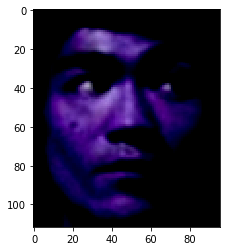

In [109]:
print(X[0][0].shape)
# print(X[0][0])
plt.imshow(X[0][0])

### Load and fit

In [46]:
print(train_dataset_path / casia_pairs[0]['fileL'])

D:\Projects\Face_Identification\sphereface_keras\train\data\CASIA-WebFace-112x96\0000045\001.jpg


In [47]:
def preprocess_image(image):
    image = (image - 127.5) / 128
    return image

X1 = []
X2 = []
Y = []
for pair in tqdm(casia_pairs_short):
    imageL = cv2.imread(str(train_dataset_path / pair['fileL']))
    imageL = preprocess_image(imageL)
    imageR = cv2.imread(str(train_dataset_path / pair['fileR']))
    imageR = preprocess_image(imageR)
    X1.append(imageL)
    X2.append(imageR)
    Y.append(pair['flag'])



  0%|                                              | 0/1200 [00:00<?, ?it/s]

 10%|███▌                              | 124/1200 [00:00<00:00, 1234.59it/s]

 21%|███████                           | 248/1200 [00:00<00:00, 1232.60it/s]

 31%|██████████▌                       | 371/1200 [00:00<00:00, 1229.88it/s]

 41%|██████████████                    | 495/1200 [00:00<00:00, 1230.52it/s]

 52%|█████████████████▌                | 619/1200 [00:00<00:00, 1232.37it/s]

 60%|█████████████████████▋              | 722/1200 [00:04<00:05, 90.49it/s]

 66%|███████████████████████▊            | 795/1200 [00:08<00:09, 41.55it/s]

 71%|█████████████████████████▍          | 847/1200 [00:10<00:11, 31.11it/s]

 74%|██████████████████████████▌         | 884/1200 [00:12<00:12, 25.49it/s]

 76%|███████████████████████████▎        | 911/1200 [00:14<00:12, 22.99it/s]

 78%|███████████████████████████▉        | 930/1200 [00:15<00:12, 21.66it/s]

 79%|████████████████████████████▎       | 944/1200 [00:15<00:

In [48]:
X1 = np.asarray(X1)
X2 = np.asarray(X2)
Y = np.asarray(Y)
X1.shape

(1200, 112, 96, 3)

In [56]:
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

def custom_loss(yTrue,yPred):
    return K.sum(K.log(yTrue) - K.log(yPred))

# def cosine_similarity(y_true, y_pred):
#     y = tf.constant([c1,c2])
#     x = K.l2_normalize(y_true, -1)
#     y = K.l2_normalize(y_pred, -1)
#     s = K.mean(x * y, axis=-1, keepdims=False) * 10
#     return s

batch_size_ = 64
epochs_ = 6

# rms_ = RMSprop()
rms_ = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-07)
loss_ = CosineSimilarity(axis=-1, name='cosine_similarity')

# model.compile(loss=loss_, optimizer=rms_, metrics=['accuracy'])
# model.compile(loss=contrastive_loss, optimizer='adam', metrics=['accuracy'])
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])

def generator_two_img(X1, X2, y, batch_size):
    generator = ImageDataGenerator()
    
    genX1 = generator.flow(X1, y,  batch_size=batch_size, seed=1)
    genX2 = generator.flow(X2, y, batch_size=batch_size, seed=1)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()
        yield [X1i[0], X2i[0]], X1i[1]

In [83]:
hist = model.fit_generator(generator_two_img(X1, X2, Y, batch_size_),
                           steps_per_epoch=len(X1)//batch_size_, 
                           epochs=epochs_,
                           callbacks = None, 
                           shuffle=True)

# https://github.com/keras-team/keras/issues/10855
# hist = model.fit(X, Y, epochs=epochs_, batch_size=batch_size_)
# hist = model.fit(x=X, 
#                  y=Y, 
#                  batch_size=batch_size_, 
#                  epochs=epochs_, 
#                  verbose=1, 
#                  callbacks=None,
#                  validation_split=0.01, 
#                  validation_data=None, 
#                  shuffle=True, 
#                  class_weight=None,
#                  sample_weight=None, 
#                  initial_epoch=0, 
#                  steps_per_epoch=None,
#                  validation_steps=None, 
#                  validation_batch_size=None, 
#                  validation_freq=1,
#                  max_queue_size=10, 
#                  workers=1, 
#                  use_multiprocessing=False)

Epoch 1/2
18/18 [==============================] - 125s 7s/step - loss: 0.2686 - accuracy: 0.6094
Epoch 2/2
18/18 [==============================] - 122s 7s/step - loss: 0.3000 - accuracy: 0.5770


In [54]:
X1[0].shape, X2[0].shape, Y[0]

((112, 96, 3), (112, 96, 3), 1)

In [62]:
X1_test = np.expand_dims(X1[0], 0)
X2_test = np.expand_dims(X2[0], 0)
print(X1_test.shape, X2_test.shape)

(1, 112, 96, 3) (1, 112, 96, 3)


In [64]:
from scipy import spatial

prediction = base_network.predict(X1_test)
print(prediction.shape)
# print(prediction

(1, 7, 6, 512)


In [64]:
for layer in base_network.layers:
    print(layer.output_shape, layer.name)
    
print(base_network.layers)

[(None, 112, 96, 3)] input_12
(None, 114, 98, 3) zero_padding2d_100
(None, 56, 48, 64) conv2d_100
(None, 56, 48, 64) p_re_lu_100
(None, 58, 50, 64) zero_padding2d_101
(None, 56, 48, 64) conv2d_101
(None, 56, 48, 64) p_re_lu_101
(None, 58, 50, 64) zero_padding2d_102
(None, 56, 48, 64) conv2d_102
(None, 56, 48, 64) p_re_lu_102
(None, 56, 48, 64) add_40
(None, 58, 50, 64) zero_padding2d_103
(None, 28, 24, 128) conv2d_103
(None, 28, 24, 128) p_re_lu_103
(None, 30, 26, 128) zero_padding2d_104
(None, 28, 24, 128) conv2d_104
(None, 28, 24, 128) p_re_lu_104
(None, 30, 26, 128) zero_padding2d_105
(None, 28, 24, 128) conv2d_105
(None, 28, 24, 128) p_re_lu_105
(None, 28, 24, 128) add_41
(None, 30, 26, 128) zero_padding2d_106
(None, 28, 24, 128) conv2d_106
(None, 28, 24, 128) p_re_lu_106
(None, 30, 26, 128) zero_padding2d_107
(None, 28, 24, 128) conv2d_107
(None, 28, 24, 128) p_re_lu_107
(None, 28, 24, 128) add_42
(None, 30, 26, 128) zero_padding2d_108
(None, 14, 12, 256) conv2d_108
(None, 14, 12,

In [114]:
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop
from keras.datasets import mnist
from keras import backend as K
from keras.models import Model
import numpy as np
import random

num_classes = 10
epochs = 20

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)


def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)


def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]
print("input shape: ", input_shape)

# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

input shape:  (28, 28)


In [ ]:
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

In [17]:
# import numpy as np
# import random
# from keras.datasets import mnist
# from keras.models import Model
# from keras.optimizers import RMSprop
# from keras import backend as K

# num_classes = 10
# epochs = 20


# def euclidean_distance(vects):
#     x, y = vects
#     sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
#     return K.sqrt(K.maximum(sum_square, K.epsilon()))


# def eucl_dist_output_shape(shapes):
#     shape1, shape2 = shapes
#     return (shape1[0], 1)


# def contrastive_loss(y_true, y_pred):
#     '''Contrastive loss from Hadsell-et-al.'06
#     http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
#     '''
#     margin = 1
#     square_pred = K.square(y_pred)
#     margin_square = K.square(K.maximum(margin - y_pred, 0))
#     return K.mean(y_true * square_pred + (1 - y_true) * margin_square)


# def create_pairs(x, digit_indices):
#     '''Positive and negative pair creation.
#     Alternates between positive and negative pairs.
#     '''
#     pairs = []
#     labels = []
#     n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
#     for d in range(num_classes):
#         for i in range(n):
#             z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
#             pairs += [[x[z1], x[z2]]]
#             inc = random.randrange(1, num_classes)
#             dn = (d + inc) % num_classes
#             z1, z2 = digit_indices[d][i], digit_indices[dn][i]
#             pairs += [[x[z1], x[z2]]]
#             labels += [1, 0]
#     return np.array(pairs), np.array(labels)


# def compute_accuracy(y_true, y_pred):
#     '''Compute classification accuracy with a fixed threshold on distances.
#     '''
#     pred = y_pred.ravel() < 0.5
#     return np.mean(pred == y_true)


# def accuracy(y_true, y_pred):
#     '''Compute classification accuracy with a fixed threshold on distances.
#     '''
#     return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


# # the data, split between train and test sets
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# x_train /= 255
# x_test /= 255
# input_shape = x_train.shape[1:]

# # create training+test positive and negative pairs
# digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
# tr_pairs, tr_y = create_pairs(x_train, digit_indices)

# digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
# te_pairs, te_y = create_pairs(x_test, digit_indices)

# # network definition
# base_network = create_base_network(input_shape)

# input_a = Input(shape=input_shape)
# input_b = Input(shape=input_shape)

# # because we re-use the same instance `base_network`,
# # the weights of the network
# # will be shared across the two branches
# processed_a = base_network(input_a)
# processed_b = base_network(input_b)

# distance = Lambda(euclidean_distance,
#                   output_shape=eucl_dist_output_shape)([processed_a, processed_b])

# model = Model([input_a, input_b], distance)

# # train
# rms = RMSprop()
# model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
# model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
#           batch_size=128,
#           epochs=epochs,
#           validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

# # compute final accuracy on training and test sets
# y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
# tr_acc = compute_accuracy(tr_y, y_pred)
# y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
# te_acc = compute_accuracy(te_y, y_pred)

# print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
# print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

ImportError: Module use of python35.dll conflicts with this version of Python.